## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

### Goals:
#### Use Scikit-Learn pipelines to define special features to add to a Naive Bayes Classifier
#### Evaluate the accuracy of the classifier
#### Maybe do it live, on a Twitter API stream

### Methods:
#### Use the training set I made before

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import nltk
import re

#### Load the CSV

In [3]:
df = pd.read_csv("../data/training_data/Subtweets_Classifier_Training_Data.csv")

#### Create training and test sets from the single training set I made before

In [4]:
text_train, text_test, class_train, class_test = train_test_split(df.alleged_subtweet.tolist(), 
                                                                  df.is_subtweet.tolist())

#### Use NLTK's tokenizer instead of Scikit's

In [5]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Class for distinguishing polarizing parts of speech as features

In [6]:
class TweetStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        first_names = ["Aaliyah", "Aaron", "Abby", "Abigail", "Abraham", "Adam",
                       "Addison", "Adrian", "Adriana", "Adrianna", "Aidan", "Aiden",
                       "Alan", "Alana", "Alejandro", "Alex", "Alexa", "Alexander",
                       "Alexandra", "Alexandria", "Alexia", "Alexis", "Alicia", "Allison",
                       "Alondra", "Alyssa", "Amanda", "Amber", "Amelia", "Amy",
                       "Ana", "Andrea", "Andres", "Andrew", "Angel", "Angela",
                       "Angelica", "Angelina", "Anna", "Anthony", "Antonio", "Ariana",
                       "Arianna", "Ashley", "Ashlyn", "Ashton", "Aubrey", "Audrey",
                       "Austin", "Autumn", "Ava", "Avery", "Ayden", "Bailey",
                       "Benjamin", "Bianca", "Blake", "Braden", "Bradley", "Brady",
                       "Brandon", "Brayden", "Breanna", "Brendan", "Brian", "Briana",
                       "Brianna", "Brittany", "Brody", "Brooke", "Brooklyn", "Bryan",
                       "Bryce", "Bryson", "Caden", "Caitlin", "Caitlyn", "Caleb",
                       "Cameron", "Camila", "Carlos", "Caroline", "Carson", "Carter",
                       "Cassandra", "Cassidy", "Catherine", "Cesar", "Charles", "Charlotte",
                       "Chase", "Chelsea", "Cheyenne", "Chloe", "Christian", "Christina",
                       "Christopher", "Claire", "Cody", "Colby", "Cole", "Colin",
                       "Collin", "Colton", "Conner", "Connor", "Cooper", "Courtney",
                       "Cristian", "Crystal", "Daisy", "Dakota", "Dalton", "Damian",
                       "Daniel", "Daniela", "Danielle", "David", "Delaney", "Derek",
                       "Destiny", "Devin", "Devon", "Diana", "Diego", "Dominic",
                       "Donovan", "Dylan", "Edgar", "Eduardo", "Edward", "Edwin",
                       "Eli", "Elias", "Elijah", "Elizabeth", "Ella", "Ellie", 
                       "Emily", "Emma", "Emmanuel", "Eric", "Erica", "Erick",
                       "Erik", "Erin", "Ethan", "Eva", "Evan", "Evelyn",
                       "Faith", "Fernando", "Francisco", "Gabriel", "Gabriela", "Gabriella",
                       "Gabrielle", "Gage", "Garrett", "Gavin", "Genesis", "George",
                       "Gianna", "Giovanni", "Giselle", "Grace", "Gracie", "Grant",
                       "Gregory", "Hailey", "Haley", "Hannah", "Hayden", "Hector",
                       "Henry", "Hope", "Hunter", "Ian", "Isaac", "Isabel",
                       "Isabella", "Isabelle", "Isaiah", "Ivan", "Jack", "Jackson",
                       "Jacob", "Jacqueline", "Jada", "Jade", "Jaden", "Jake",
                       "Jalen", "James", "Jared", "Jasmin", "Jasmine", "Jason", 
                       "Javier", "Jayden", "Jayla", "Jazmin", "Jeffrey", "Jenna",
                       "Jennifer", "Jeremiah", "Jeremy", "Jesse", "Jessica", "Jesus",
                       "Jillian", "Jocelyn", "Joel", "John", "Johnathan", "Jonah",
                       "Jonathan", "Jordan", "Jordyn", "Jorge", "Jose", "Joseph",
                       "Joshua", "Josiah", "Juan", "Julia", "Julian", "Juliana",
                       "Justin", "Kaden", "Kaitlyn", "Kaleb", "Karen", "Karina",
                       "Kate", "Katelyn", "Katherine", "Kathryn", "Katie", "Kayla",
                       "Kaylee", "Kelly", "Kelsey", "Kendall", "Kennedy", "Kenneth",
                       "Kevin", "Kiara", "Kimberly", "Kyle", "Kylee", "Kylie",
                       "Landon", "Laura", "Lauren", "Layla", "Leah", "Leonardo",
                       "Leslie", "Levi", "Liam", "Liliana", "Lillian", "Lilly",
                       "Lily", "Lindsey", "Logan", "Lucas", "Lucy", "Luis",
                       "Luke", "Lydia", "Mackenzie", "Madeline", "Madelyn", "Madison",
                       "Makayla", "Makenzie", "Malachi", "Manuel", "Marco", "Marcus",
                       "Margaret", "Maria", "Mariah", "Mario", "Marissa", "Mark",
                       "Martin", "Mary", "Mason", "Matthew", "Max", "Maxwell",
                       "Maya", "Mckenzie", "Megan", "Melanie", "Melissa", "Mia",
                       "Micah", "Michael", "Michelle", "Miguel", "Mikayla", "Miranda",
                       "Molly", "Morgan", "Mya", "Naomi", "Natalia", "Natalie",
                       "Nathan", "Nathaniel", "Nevaeh", "Nicholas", "Nicolas", "Nicole",
                       "Noah", "Nolan", "Oliver", "Olivia", "Omar", "Oscar",
                       "Owen", "Paige", "Parker", "Patrick", "Paul", "Payton",
                       "Peter", "Peyton", "Preston", "Rachel", "Raymond", "Reagan",
                       "Rebecca", "Ricardo", "Richard", "Riley", "Robert", "Ruby",
                       "Ryan", "Rylee", "Sabrina", "Sadie", "Samantha", "Samuel",
                       "Sara", "Sarah", "Savannah", "Sean", "Sebastian", "Serenity",
                       "Sergio", "Seth", "Shane", "Shawn", "Shelby", "Sierra",
                       "Skylar", "Sofia", "Sophia", "Sophie", "Spencer", "Stephanie",
                       "Stephen", "Steven", "Summer", "Sydney", "Tanner", "Taylor", 
                       "Thomas", "Tiffany", "Timothy", "Travis", "Trenton", "Trevor",
                       "Trinity", "Tristan", "Tyler", "Valeria", "Valerie", "Vanessa",
                       "Veronica", "Victor", "Victoria", "Vincent", "Wesley", "William",
                       "Wyatt", "Xavier", "Zachary", "Zoe", "Zoey"]
        first_names_lower = set([name.lower() for name in first_names])

        personal_pronouns = ["I", "Me", "We", "Us", "You", "She", "Her", "He", "Him", "They", "Them"]
        personal_prounouns_lower = [pronoun.lower() for pronoun in personal_pronouns]

        possessive_pronouns = ["My", "Your", "Our", "Their", "His", "Her", "Hers", "Yours", "Ours", "Theirs"]
        possessive_pronouns_lower = [possessive_pronoun.lower() for possessive_pronoun in possessive_pronouns]

        important_parts_of_speech = set(personal_prounouns_lower + possessive_pronouns_lower)
        pattern = "(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
                
        final_output = []
        for text in posts:
            tokenized_text = tokenizer.tokenize(text)
            weighted_dict = {"length": len(text), 
                             "good": len(important_parts_of_speech.intersection(tokenizer.tokenize(text))), 
                             "bad": (len(first_names_lower.intersection(tokenizer.tokenize(text))) 
                                     + text.count("@") 
                                     + text.count("subtweet") 
                                     + text.count("Subtweet") 
                                     + len(re.findall(pattern, text)))}
            final_output.append(weighted_dict)
        return final_output

#### Build the pipeline

In [7]:
sentiment_pipeline = Pipeline([
    ("features", FeatureUnion([
        ("ngram_tf_idf", Pipeline([
            ("counts", CountVectorizer(tokenizer=tokenizer.tokenize)),
            ("tf_idf", TfidfTransformer())
        ])),
        ("stats_vect", Pipeline([
            ("tweet_stats", TweetStats()),
            ("vect", DictVectorizer()),
        ])),
    ])),
    ("classifier", MultinomialNB())
])

#### Show the results

In [8]:
sentiment_pipeline.fit(text_train, class_train)
predictions = sentiment_pipeline.predict(text_test)

In [9]:
print(classification_report(class_test, predictions))

             precision    recall  f1-score   support

   negative       0.94      0.87      0.90      1833
   positive       0.87      0.94      0.91      1794

avg / total       0.91      0.90      0.90      3627



#### Define function for visualizing confusion matrices

In [10]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Show the matrices

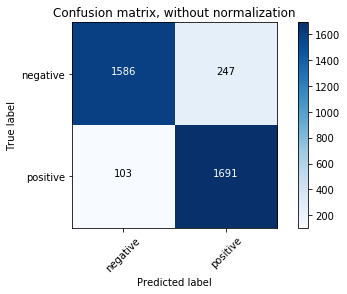

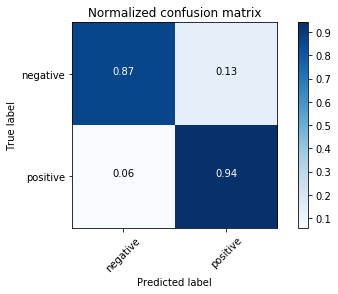

In [11]:
class_names = ["negative", "positive"]

cnf_matrix = confusion_matrix(class_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Save the classifier for another time

In [12]:
joblib.dump(sentiment_pipeline, "../data/non_subtweets_data/subtweets_classifier.pkl") 

['../data/non_subtweets_data/subtweets_classifier.pkl']

#### Print tests for the classifier

In [13]:
def print_tests(tweets_dataframe, 
                text_column="SentimentText", sentiment_column="Sentiment", 
                threshold=0.95):
    tweets = tweets_dataframe[text_column].tolist()
    sentiments = tweets_dataframe[sentiment_column].tolist()
    total_subtweets = 0
    print("Probabilities:\n")
    for i in range(len(tweets)):
        tweet = tweets[i]
        prediction = sentiment_pipeline.predict([tweets[i]]).tolist()[0]
        sentiment = sentiments[i]
        negative_probability = sentiment_pipeline.predict_proba([tweets[i]]).tolist()[0][0]
        positive_probability = sentiment_pipeline.predict_proba([tweets[i]]).tolist()[0][1]
        if positive_probability >= threshold:
            total_subtweets += 1
            print(("\"{}\" was classified as {}:" 
                   + "\nSentiment Score: {}" 
                   + "\nNot a subtweet: {:.1%}" 
                   + "\nSubtweet: {:.1%}").format(tweet, prediction, sentiment,
                                                  negative_probability, 
                                                  positive_probability))
            print()
    print("Total number of subtweets according to the classifier: {}".format(total_subtweets))

#### Make up some tweets

In [14]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [15]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Print the tests

In [16]:
print_tests(test_tweets_df, text_column="Tweet", sentiment_column="Sentiment", threshold=0.5)

Probabilities:

"Some people don't know their place." was classified as positive:
Sentiment Score: None
Not a subtweet: 11.9%
Subtweet: 88.1%

"Isn't it funny how some people don't know their place?" was classified as positive:
Sentiment Score: None
Not a subtweet: 10.9%
Subtweet: 89.1%

"How come you people act like this?" was classified as positive:
Sentiment Score: None
Not a subtweet: 7.4%
Subtweet: 92.6%

"You're such a nerd." was classified as positive:
Sentiment Score: None
Not a subtweet: 46.2%
Subtweet: 53.8%

Total number of subtweets according to the classifier: 4


#### Test on actual tweets

In [17]:
naji_df = pd.read_csv("../data/non_subtweets_data/naji_data.csv", error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


#### Repair some leftover HTML

In [18]:
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&quot;", "\"")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&amp;", "&")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&gt;", ">")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&lt;", "<")

# Use randomly selected 250K rows from dataset

In [19]:
naji_df = naji_df.sample(n=250000).reset_index(drop=True)

#### Print and time the tests

In [20]:
%%time
print_tests(naji_df, threshold=0.975)

Probabilities:

"Shoppers are the worst people ever. No, the ones who call themselvs "Hunters" are THE worst. Hunt my nuts out of your hair. Loser. " was classified as positive:
Sentiment Score: 0
Not a subtweet: 2.2%
Subtweet: 97.8%

"reminicing on a lot if shit  if only we could hold each other a few more nights  i h8 u bc ur w/ him instead of me" was classified as positive:
Sentiment Score: 0
Not a subtweet: 1.6%
Subtweet: 98.4%

"hate the fact that you walk past a person like they were never a part of you, when they were the biggest part of your life " was classified as positive:
Sentiment Score: 0
Not a subtweet: 2.3%
Subtweet: 97.7%

"Just witnessed a man threatning to beat a woman every fucking day if she didn't shut her fucking mouth. Shit. He looked me in the eyes " was classified as positive:
Sentiment Score: 0
Not a subtweet: 1.4%
Subtweet: 98.6%

"I wonder how people talk about their latex fetish these days. Do they wear a hood to hide their thoughts and personality? " was 